### Import libraries and utilities

In [41]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import pearsonr, spearmanr
from math import log
import itertools
import plotly.graph_objects as go
sns.set_theme(style="whitegrid")


In [29]:
num_feature = ['danceability', 'energy', 'loudness',
               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
# lists for discretizing data
eras = [1980, 1990, 2000, 2010, 2015, 2018]
popularity = [500000000]

key_dict = {
    "0": "C",
    "1": "C♯",
    "2": "D",
    "3": "D♯",
    "4": "E",
    "5": "F",
    "6": "F♯",
    "7": "G",
    "8": "G♯",
    "9": "A",
    "10": "A♯",
    "11": "B"
}

mode = ["minor", "major"]


def convert_key(col):
    return col.apply(lambda x: key_dict[str(x)])


def convert_mode(col):
    return col.apply(lambda x: mode[x])


def convert_time_sig(col):
    return col.apply(lambda x: "{}/4".format(x))


def convert_duration(col):
    return col.apply(lambda x: sum(mul * int(x) for mul, x in zip([60, 1], x.split(":"))))


def get_corr_matrix(df, feature, p=False):
    pearson_view = {}
    pp_view = {}
    pearson_playcount = {}
    pp_playcount = {}
    spearman_view = {}
    sp_view = {}
    spearman_playcount = {}
    sp_playcount = {}

    for col in feature:
        pearson_playcount[col], pp_playcount[col] = pearsonr(
            df['playcount'], df[col])
        pearson_view[col], pp_view[col] = pearsonr(df['view'], df[col])
        spearman_view[col], sp_view[col] = spearmanr(df['view'], df[col])
        spearman_playcount[col], sp_playcount[col] = spearmanr(
            df['playcount'], df[col])

    corr = pd.DataFrame(columns=feature)
    corr = corr.append(pearson_playcount, ignore_index=True)
    corr = corr.append(pearson_view, ignore_index=True)
    corr = corr.append(spearman_playcount, ignore_index=True)
    corr = corr.append(spearman_view, ignore_index=True)
    corr['type'] = ['pearson_playcount', 'pearson_view',
                    'spearman_playcount', 'spearman_view']
    corr = corr.set_index("type")

    if p:
        p_value = pd.DataFrame(columns=feature)
        p_value = p_value.append(pp_playcount, ignore_index=True)
        p_value = p_value.append(pp_view, ignore_index=True)
        p_value = p_value.append(sp_playcount, ignore_index=True)
        p_value = p_value.append(sp_view, ignore_index=True)
        return corr, p_value

    return corr


def findsubsets(S, m):
    return set(itertools.combinations(S, m))


class ConfusionMatrix():
    def __init__(self, list):
        self.ele = list
        self.size = len(list)
        self.matrix = np.zeros((len(list), len(list)))

    def increment(self, pair):
        first_ele, second_ele = pair
        first_i = self.ele.index(first_ele)
        second_i = self.ele.index(second_ele)
        self.matrix[first_i, second_i] += 1
        self.matrix[second_i, first_i] += 1

    def update_diag(self, ele, value):
        i = self.ele.index(ele)
        self.matrix[i, i] = value

    def normalize(self):
        """
        Divide each value in the matrix (except the values on the diagonal) by the its expected value
        """
        total = np.diag(self.matrix).sum()
        for i in range(self.size):
            for j in range(i):
                self.matrix[i, j] /= self.matrix[i, i] * \
                    self.matrix[j, j] / total
                self.matrix[j, i] = self.matrix[i, j]

    def reset_diag(self):
        for i in range(self.size):
            self.matrix[i, i] = 0


def gini(df, col):
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 1 - (prob ** 2).sum()


def entropy(df, col):
    df = pd.DataFrame([1, 2, 0])
    col = 0
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 0 - (prob * prob.apply(log)).sum()


def plot_popularity_by_year(data, **kwargs):
    # ax = plt.gca()
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    popularity_by_year = df_year.groupby("year")[["playcount", "view"]].mean()
    # years with no song will have mean view and playcount of 0
    # also convert everything to float since map_dataframe wants that for some reason
    popularity_by_year.index = popularity_by_year.index.astype('float64')
    all_year = set(popularity_by_year.index)
    earliest = min(all_year)
    latest = max(all_year)
    for year in range(int(earliest)+1, int(latest)):
        year = float(year)
        if year not in all_year:
            popularity_by_year = popularity_by_year.append(pd.DataFrame(
                [[0, 0]], columns=popularity_by_year.columns, index=[year]))
    sns.lineplot(data=popularity_by_year)


def plot_popularity_by_eras(data, **kwargs):
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    eras_mean = discretize(data=df_year, col='year', value_range=eras, inf='both').groupby(
        'year')[['playcount', 'view']].mean()
    ax = plt.gca()
    ax.set_xticks([i for i in range(len(eras_mean))], [
                  "<1980", "1980s", "1990s", "2000s", "2010-2014", "2015-2017", "2018-now"])
    sns.lineplot(data=eras_mean.reset_index(drop=True))


def build_interval(value_range, inf):
    assert inf in ['left', 'right', 'both', 'neither']
    intervals = []
    for i, ele in enumerate(value_range):
        if i == 0:
            if inf == 'left' or inf == 'both':
                intervals.append((-np.inf, ele))
            intervals.append((ele, value_range[i+1]))
        elif i == len(value_range) - 1:
            if inf == 'right' or inf == 'both':
                intervals.append((ele, np.inf))
        else:
            intervals.append((ele, value_range[i+1]))
    return pd.IntervalIndex.from_tuples(intervals)


def discretize(data, col, value_range, inf='right'):
    intervals = build_interval(value_range, inf)
    df_copy = data.copy()
    df_copy[col] = pd.cut(df_copy[col], intervals)
    return df_copy


### Import data

In [42]:
df = pd.read_csv("full.csv")
df_with_genre = pd.read_csv("full_with_genre.csv")
df["sp_release_date"] = pd.to_datetime(
    df['sp_release_date'], format='%Y-%m-%d')
df_with_genre["sp_release_date"] = pd.to_datetime(
    df_with_genre['sp_release_date'], format='%Y-%m-%d')
# df = df[df["view"] > 1e6]
# len(df)
print(df.columns)
print(len(df_with_genre))
df.head(2)


Index(['track', 'track_id', 'artist', 'album', 'sp_release_date', 'duration',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'playcount', 'video_id', 'view', 'channelTitle',
       'yt_release_date', 'title'],
      dtype='object')
6074


,track,track_id,artist,album,sp_release_date,duration,explicit,danceability,energy,key,...,liveness,valence,tempo,time_signature,playcount,video_id,view,channelTitle,yt_release_date,title
0,Shape of You,0FE9t6xYkqWXU2ahLh6D8X,Ed Sheeran,Shape of You,2017-01-06,234,False,0.825,0.652,C♯,...,0.0931,0.931,95.977,4/4,2971854102,JGwWNGJdvx8,5533840092,Ed Sheeran,2017-01-30T10:57:50Z,Ed Sheeran - Shape of You (Official Music Video)
1,Blinding Lights,0sf12qNH5qcw8qpgymFOqD,The Weeknd,Blinding Lights,2019-11-29,202,False,0.513,0.796,C♯,...,0.0938,0.345,171.017,4/4,2636804603,fHI8X4OXluQ,611764719,TheWeekndVEVO,2019-11-29T05:00:08Z,The Weeknd - Blinding Lights (Official Audio)


### Correlation between each numeric variable and playcount, view

#### For the whole dataset

<AxesSubplot:ylabel='type'>

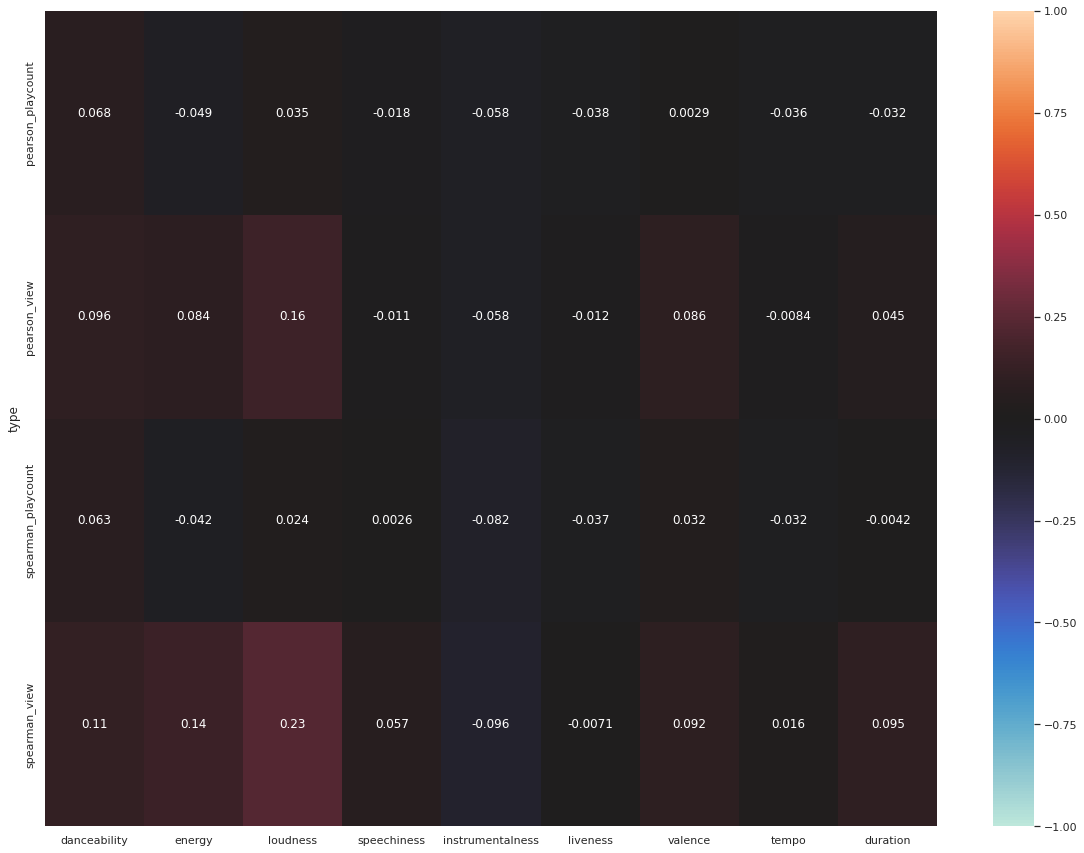

In [64]:
corr = get_corr_matrix(df, num_feature)

plt.figure(figsize=(20, 15))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0)


#### For each genre

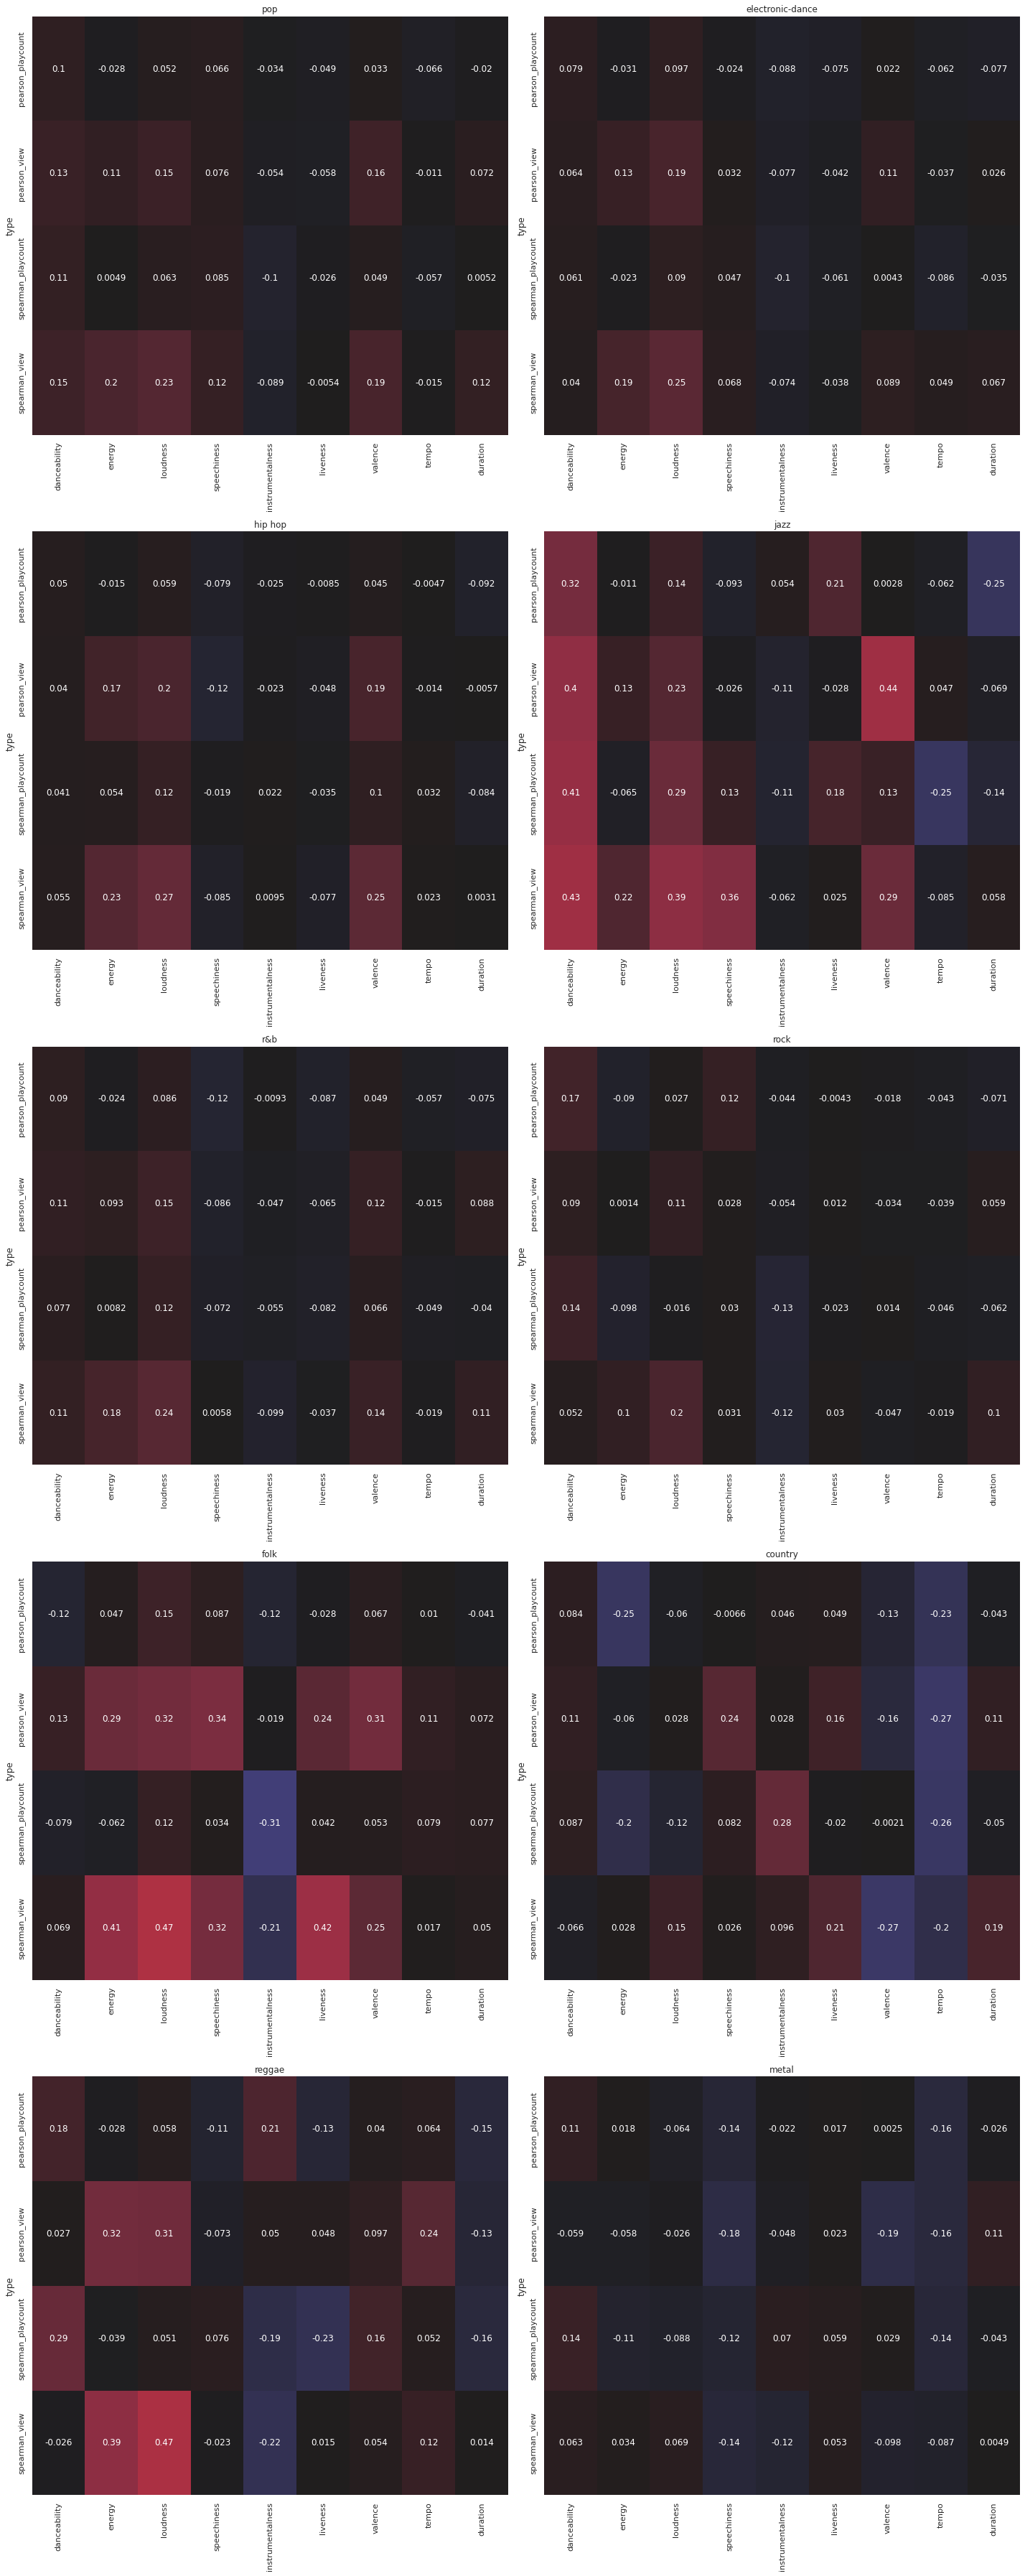

In [86]:
genres = df_with_genre["genres"].dropna().unique()
f, ax = plt.subplots(5, 2, figsize=(20, 50))
for i, genre in enumerate(genres):
    col = i % 2
    row = (i // 2) % 5
    corr = get_corr_matrix(
        df_with_genre[df_with_genre["genres"] == genre], num_feature)
    sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                ax=ax[row, col], cbar=False, annot=True, label=genre)
    ax[row, col].set_title(genre)
f.tight_layout()


### Plot distributrion and basic statistics

In [5]:
stat_dict = {}
for f in num_feature:
    stat_dict[f] = {}

for f in num_feature:{
    '<1980': first_chunk['playcount'].mean(),
    '1980s': second_chunk['playcount'].mean(),
    '1990s': third_chunk['playcount'].mean(),
    '2000s': forth_chunk['playcount'].mean(),
    '2010-2015': fifth_chunk['playcount'].mean(),
    '2015-2017': sixth_chunk['playcount'].mean(),
    '2018-now': seventh_chunk['playcount'].mean()
}
    # print(mean)
    variance = df[f].var(axis=0)
    stat_dict[f]['variance'] = variance
    # print(variance)
    skewness = df[f].skew(axis=0)
    stat_dict[f]['skewness'] = skewness
    # print(skewness)
    kurtosis = df[f].kurt(axis=0)
    stat_dict[f]['kurtosis'] = kurtosis

    # print(kurtosis)

stat_dict

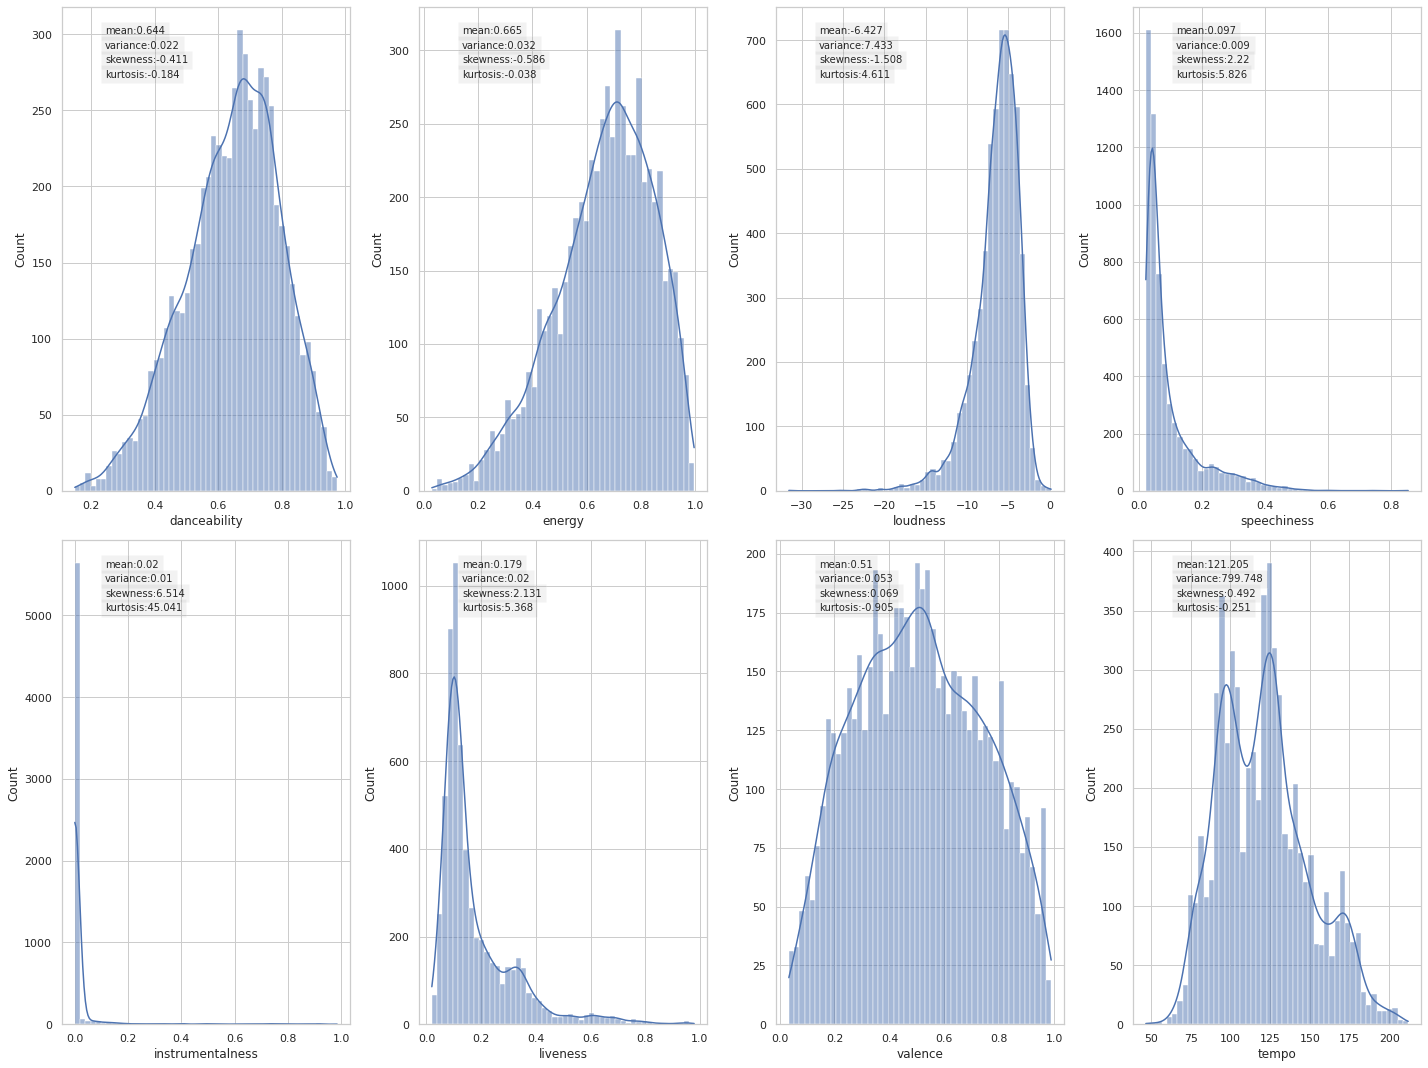

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for i in range(len(feature)):
    if feature[i] == "duration":
        continue
    if i < 4:
        row = 0
    else:
        row = 1
    col = i % 4
    for j, key in enumerate(stat_dict[feature[i]].keys()):
        ax[row, col].text(0.15, 0.95 - j * 0.03, '{}:{}'.format(key, round(stat_dict[feature[i]][key], 3)), size=10,
                          verticalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='grey', alpha=0.1))
    sns.histplot(data=df, x=feature[i], ax=ax[row, col], kde=True, bins=50)
fig.tight_layout()


#### Duration distribution

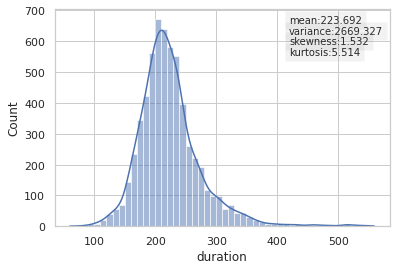

In [8]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="duration", kde=True, bins=50, ax=ax)
for j, key in enumerate(stat_dict["duration"].keys()):
    ax.text(0.7, 0.95 - j * 0.05, '{}:{}'.format(key, round(stat_dict["duration"][key], 3)), size=10,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))


### Correlation between playcount and view

In [9]:
df['playcount'].corr(df['view'], method='spearman')


0.5756345163642145

<AxesSubplot:xlabel='playcount', ylabel='view'>

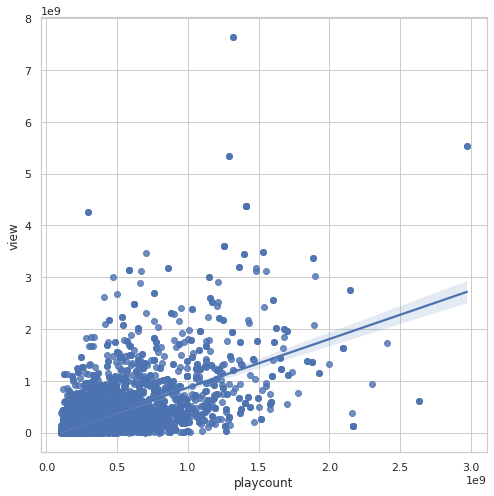

In [10]:
f, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x="playcount", y="view", ax=ax)


### Counts of each mode with different playcount bins

#### Shitty population pyramid

In [11]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
df["bins"] = pd.cut(df["playcount"], bins)


In [12]:
pop_dist_0 = df[df["mode"] == "minor"].groupby("bins")[["playcount"]].count()
pop_dist_1 = df[df["mode"] == "major"].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["major"] = pop_dist_0['playcount']
pop_dist["minor"] = pop_dist_1['playcount'].apply(lambda x: 0 - x)
pop_dist = pop_dist.reset_index()


In [13]:
pop_dist


,bins,major,minor
0,"(0.0, 200000000.0]",860,-1228
1,"(200000000.0, 300000000.0]",523,-900
2,"(300000000.0, 400000000.0]",314,-466
3,"(400000000.0, 500000000.0]",210,-310
4,"(500000000.0, 750000000.0]",252,-398
5,"(750000000.0, 1000000000.0]",131,-188
6,"(1000000000.0, 3000000000.0]",127,-180


Text(0.5, 0, 'bruh')

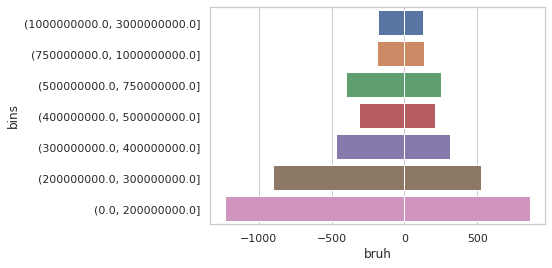

In [14]:
sns.barplot(x="major", y="bins", data=pop_dist, order=bins[::-1])
sns.barplot(x="minor", y="bins", data=pop_dist, order=bins[::-1])
plt.xlabel("bruh")


#### Epic lollipop plot

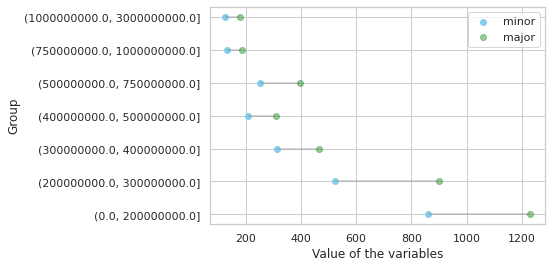

In [15]:
pop_dist_0 = df[df["mode"] == "minor"].groupby("bins")[["playcount"]].count()
pop_dist_1 = df[df["mode"] == "major"].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["minor"] = pop_dist_0['playcount']
pop_dist["major"] = pop_dist_1['playcount']
pop_dist = pop_dist.reset_index()
my_range = range(1, len(pop_dist.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=pop_dist['minor'],
           xmax=pop_dist['major'], color='grey', alpha=0.4)
plt.scatter(pop_dist['minor'], my_range,
            color='skyblue', alpha=1, label='minor')
plt.scatter(pop_dist['major'], my_range,
            color='green', alpha=0.4, label='major')
plt.legend()

# Add title and axis names
plt.yticks(my_range, pop_dist['bins'])
plt.xlabel('Value of the variables')
plt.ylabel('Group')

# Show the graph
plt.show()


### Scatter plot of view and playcount corresponding to the "explicit" variable

explicit
False    4376
True     1711
Name: track_id, dtype: int64


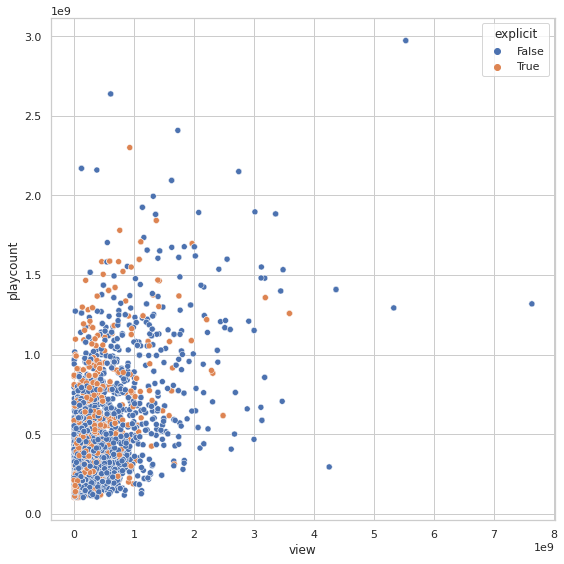

In [16]:
print(df.groupby('explicit')['track_id'].count())
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
f.tight_layout()


### Strip plot of the playcount and view of each key

<AxesSubplot:xlabel='key', ylabel='view'>

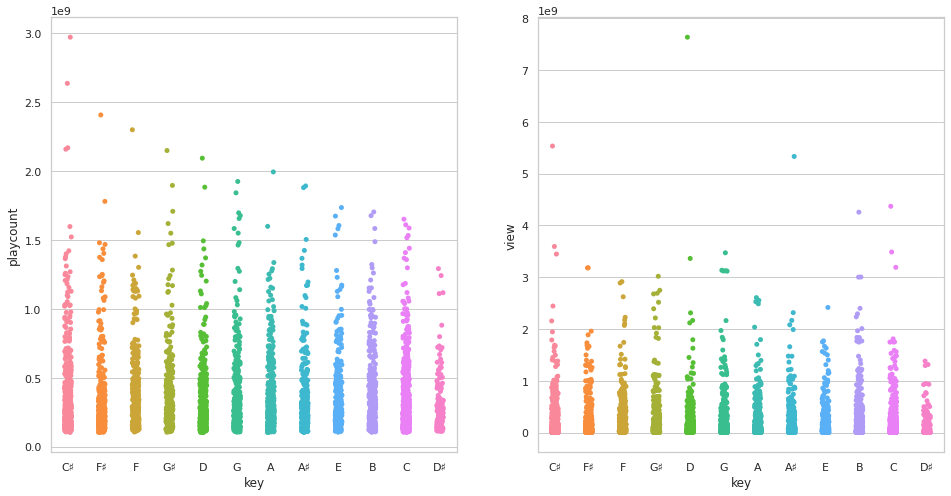

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.stripplot(x="key", y="playcount", data=df, ax=ax[0])
sns.stripplot(x="key", y="view", data=df, ax=ax[1])


### Bar plot of the counts of each categorical variable

#### Explicit

<AxesSubplot:xlabel='explicit', ylabel='count'>

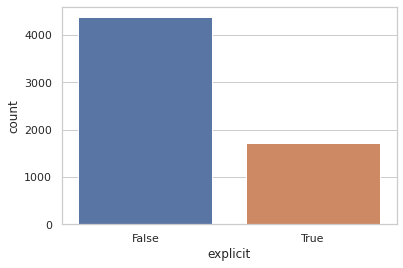

In [20]:
sns.countplot(x="explicit", data=df, order=df['explicit'].value_counts().index)


#### Key

Text(0.9, 0.91, 'Entropy=1.1')

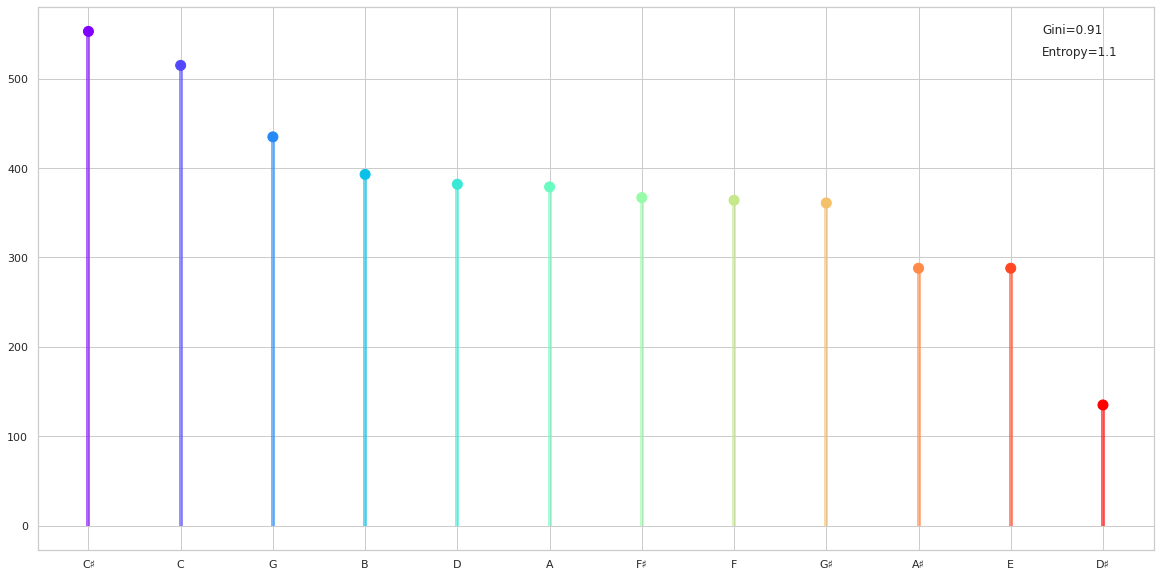

In [16]:
# sns.countplot(x="key", data=df, order=df['key'].value_counts().index)
fig, ax = plt.subplots(figsize=(20, 10))
key_count = df['key'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(key_count)))
my_range = np.arange(len(key_count))
ax.vlines(x=my_range, ymin=0, ymax=key_count - 5,
          alpha=0.6, linewidth=4, colors=colors)
ax.scatter(x=my_range, y=key_count, s=100, c=colors)
ax.set_xticks(my_range, key_count.index)
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df, 'key'), 2)), transform=ax.transAxes)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df, 'key'), 2)), transform=ax.transAxes)


#### Time signature

<AxesSubplot:xlabel='time_signature', ylabel='count'>

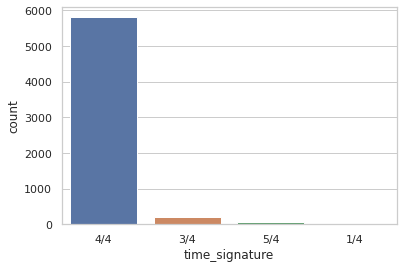

In [22]:
sns.countplot(x="time_signature", data=df,
              order=df['time_signature'].value_counts().index)


#### Mode

<AxesSubplot:xlabel='mode', ylabel='count'>

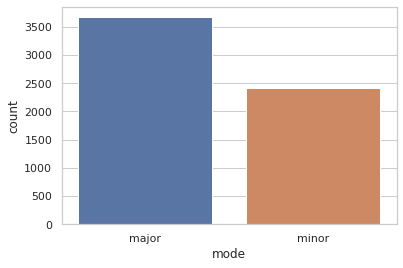

In [23]:
sns.countplot(x="mode", data=df, order=df['mode'].value_counts().index)


### Artists with the highest number of hits

<AxesSubplot:xlabel='count', ylabel='artist'>

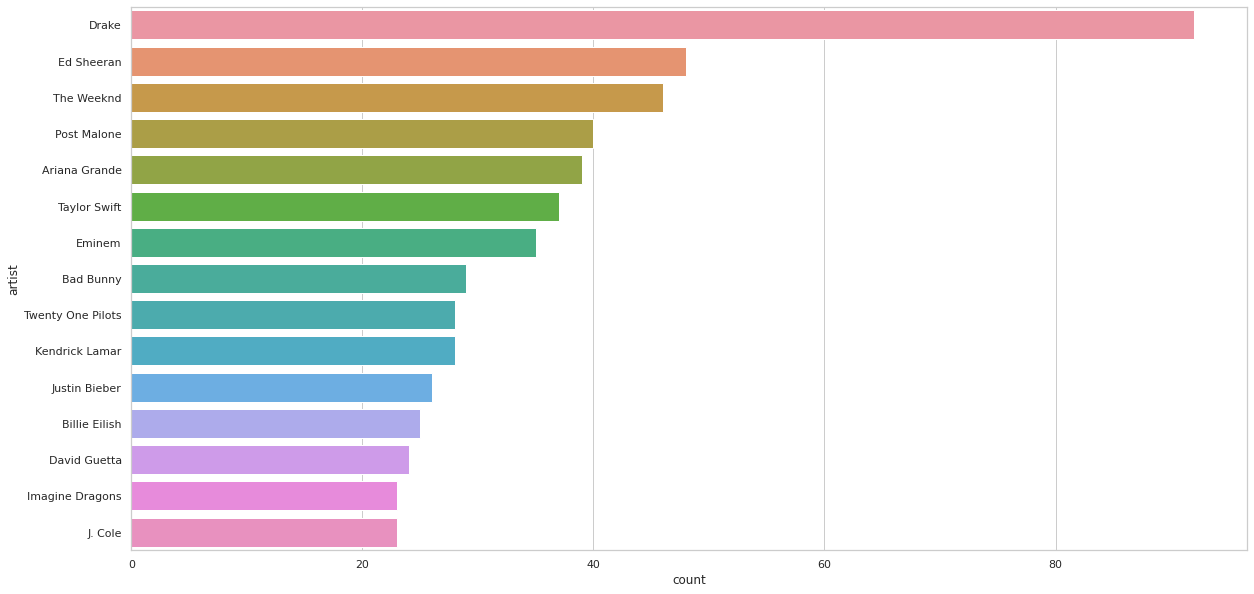

In [36]:
plt.figure(figsize=(20, 10))
df_no_various_artist = df[df["artist"] != "Various Artists"]
# artist_count = df_no_various_artist["artist"].value_counts().reset_index()
# num_artist = 15
# plt.hlines(y=range(num_artist), xmin=0, xmax=artist_count["artist"][:num_artist], color='grey', alpha=0.4)
# plt.scatter(y=range(num_artist), x=artist_count["artist"][:num_artist], s=200, alpha=0.8)
# plt.xticks(range())
sns.countplot(y="artist", data=df_no_various_artist,
              order=df_no_various_artist['artist'].value_counts().index[0:15])


In [ ]:
f, ax = plt.subplots(2, 5)
sns.catplot(x="artist", y="playcount",
            col="genres", data=df_with_genre, col_wrap=5)


### Genre

#### The count of each genre

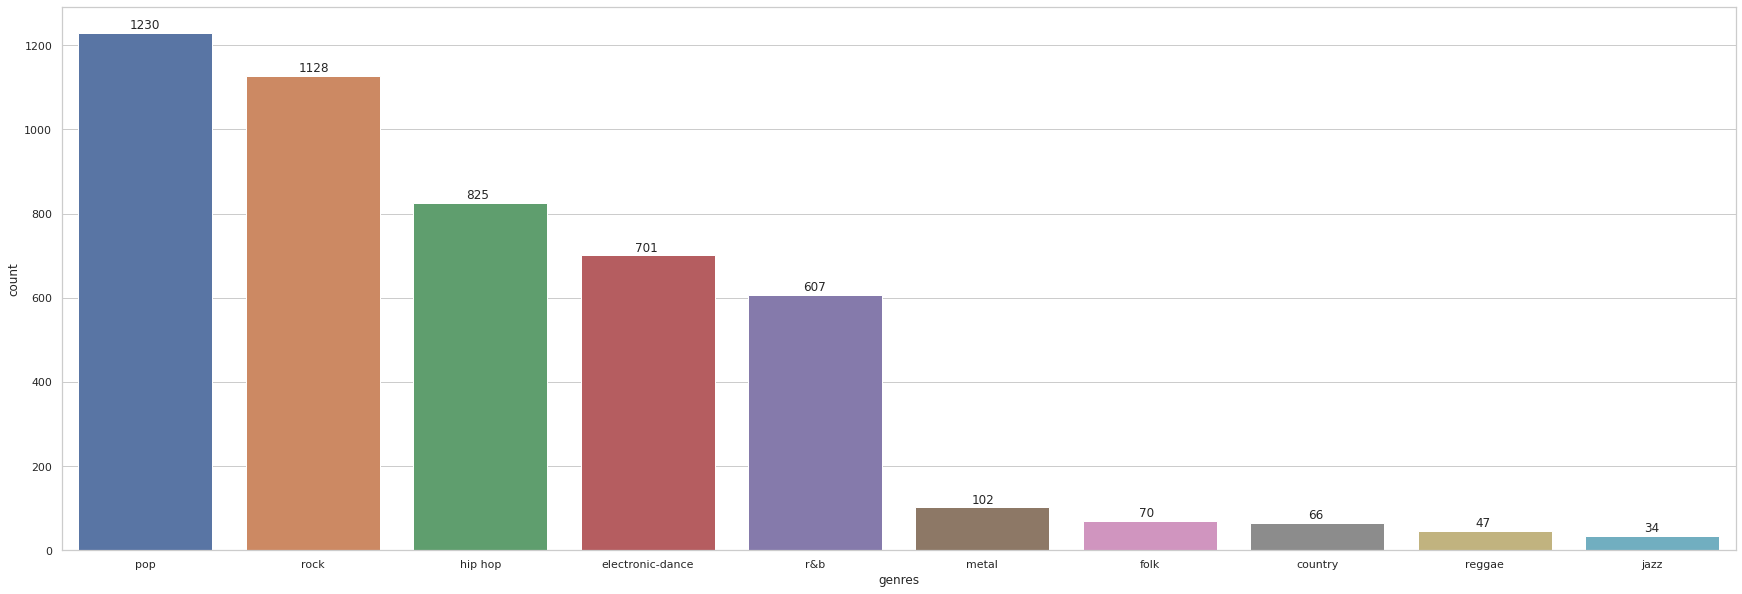

In [5]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(x="genres", data=df_with_genre,
              order=df_with_genre['genres'].value_counts(dropna=True).index, ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *
                1.005 + 0.31, p.get_height() + 10))


#### Playcount and view distribution with respect to each genre

<AxesSubplot:xlabel='genres', ylabel='view'>

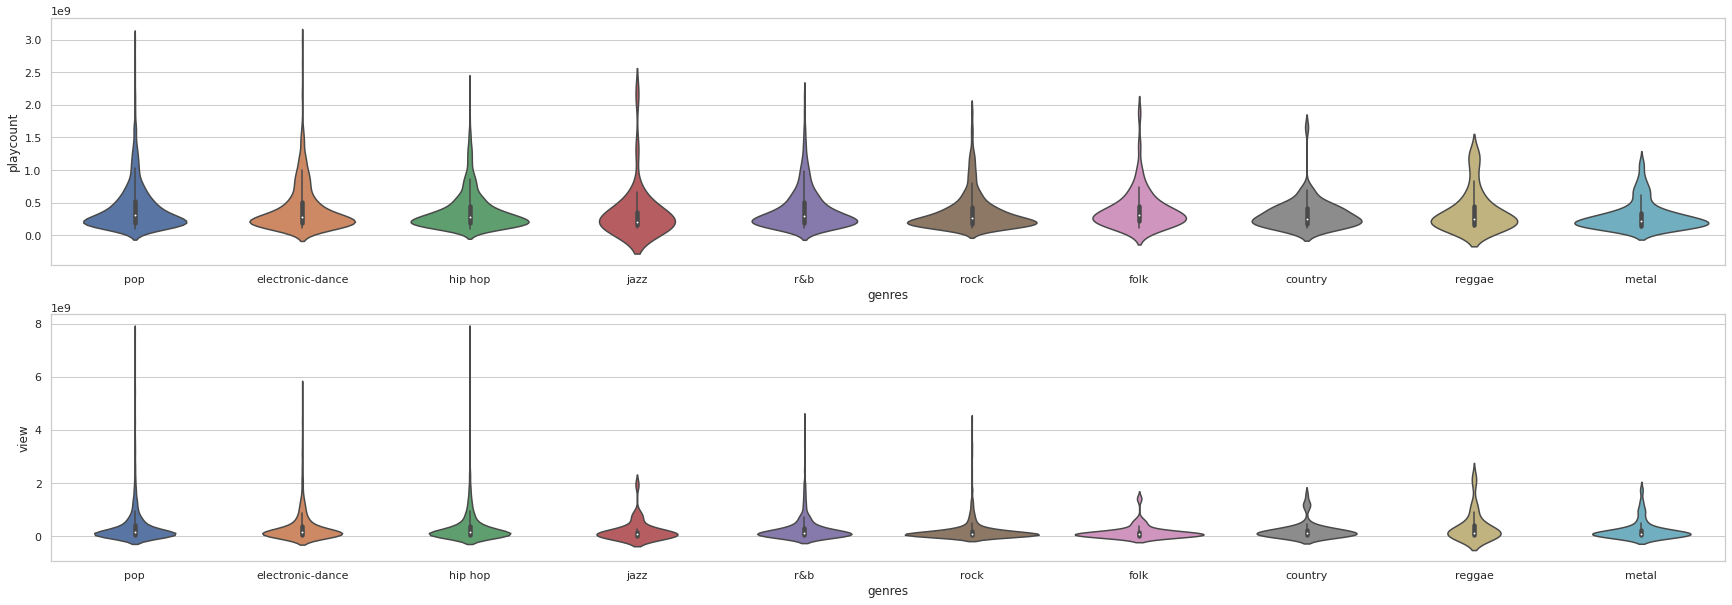

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(30, 10))
sns.violinplot(x="genres", y="playcount", data=df_with_genre, ax=ax[0])
sns.violinplot(x="genres", y="view", data=df_with_genre, ax=ax[1])


/home/viet/anaconda3/envs/eda/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/viet/anaconda3/envs/eda/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


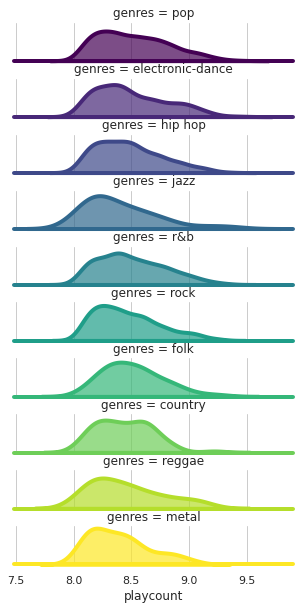

In [75]:
cmap = cm.get_cmap('viridis')


def add_genre_left(**kws):
    ax = plt.gca()
    ax.set_ylabel("wut")


d = {'color': [cmap(i) for i in np.linspace(0, 1, 10)]}
df_log = df_with_genre.copy()
df_log["playcount"] = df_log["playcount"].apply(lambda x: log(x, 10))
ridge_plot = sns.FacetGrid(df_log, row="genres", hue="genres",
                           aspect=5, height=1, hue_kws=d, gridspec_kws={"hspace": 0.4})

ridge_plot.map(sns.kdeplot, 'playcount', clip_on=False,
               shade=True, alpha=0.7, lw=4)
# ridge_plot.fig.subplots_adjust(hspace=-0.1)
ridge_plot.map(plt.axhline, y=-0.009, lw=4, clip_on=False)
ridge_plot.map(add_genre_left)
ridge_plot.set(yticks=[])
ridge_plot.set_ylabels("")
# ridge_plot.set(title="")
ridge_plot.despine(bottom=True, left=True)


#### Mean views and playcounts of the explicit and non-explicit songs of each genre

<AxesSubplot:xlabel='genres', ylabel='view'>

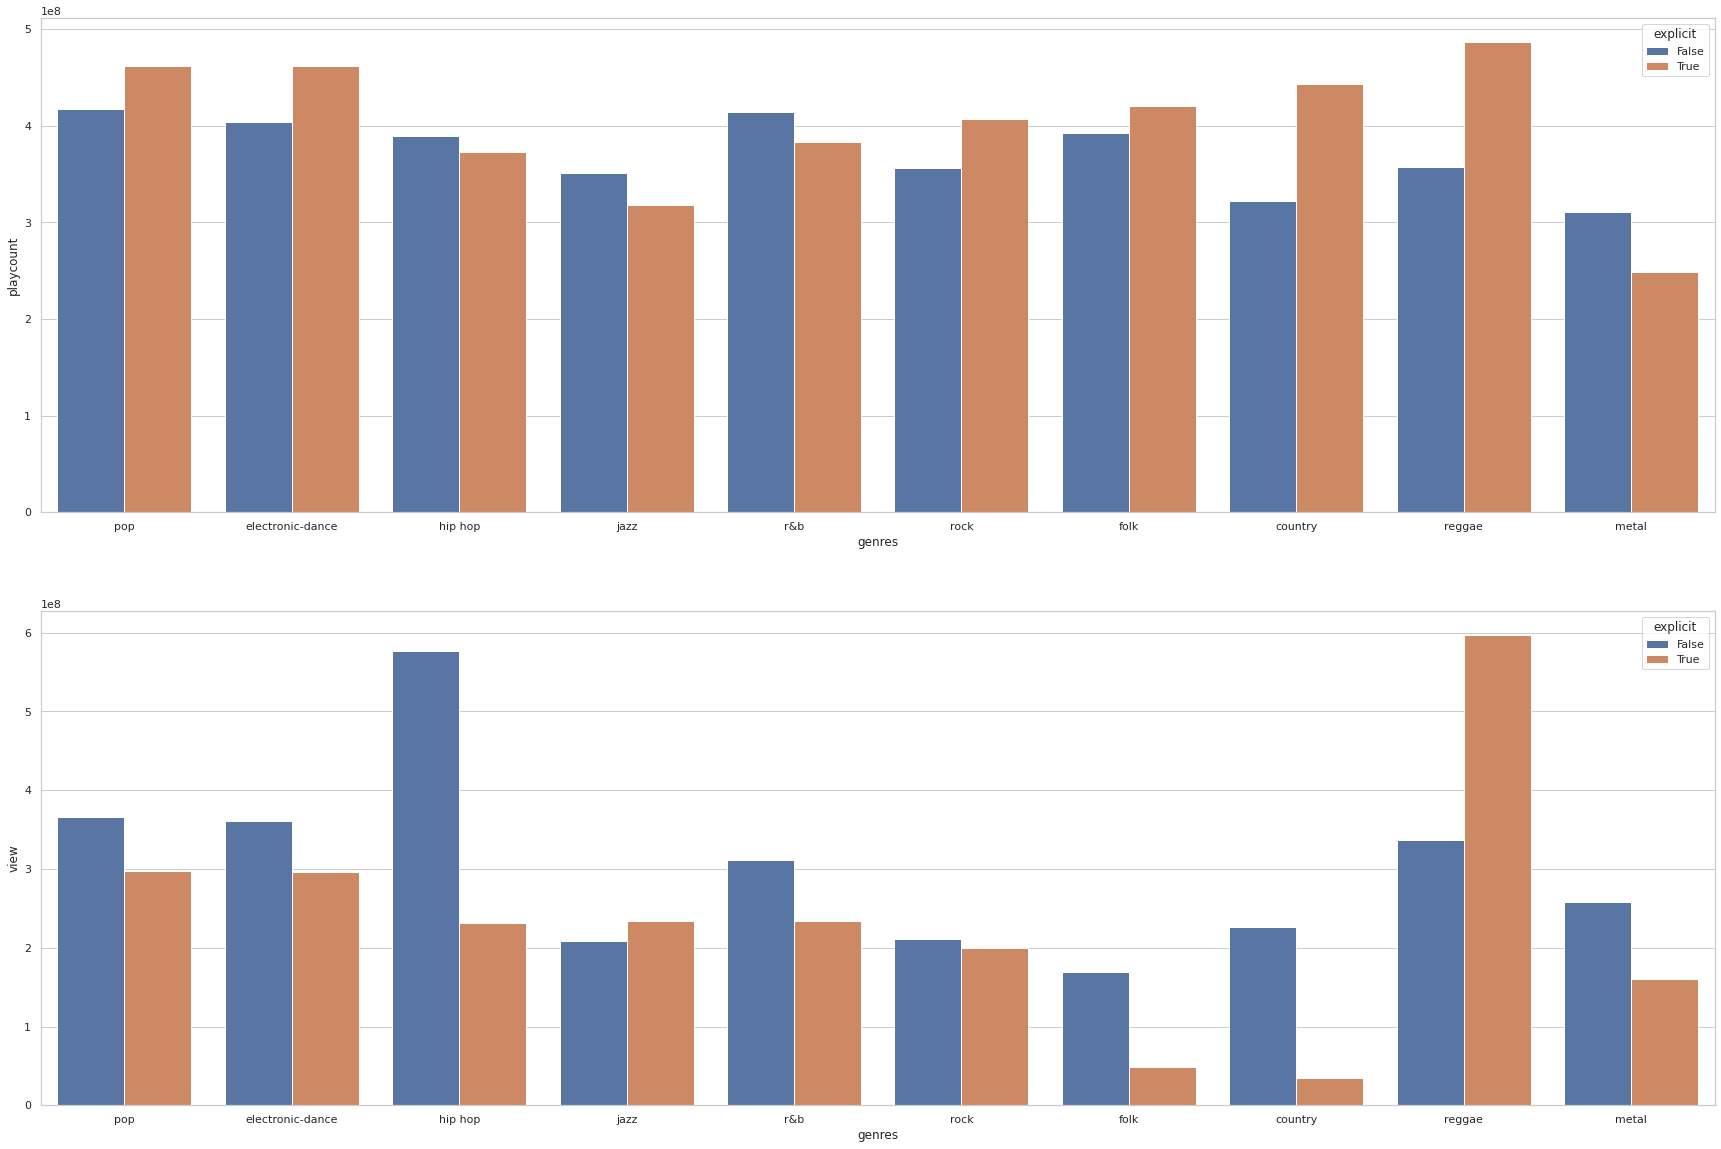

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(30, 20))
sns.barplot(x="genres", y="playcount", data=df_with_genre,
            ax=ax[0], ci=None, hue="explicit")
sns.barplot(x="genres", y="view", data=df_with_genre,
            ax=ax[1], ci=None, hue="explicit")


#### Distribution of some numeric features with respect to each genre

<AxesSubplot:xlabel='genres', ylabel='danceability'>

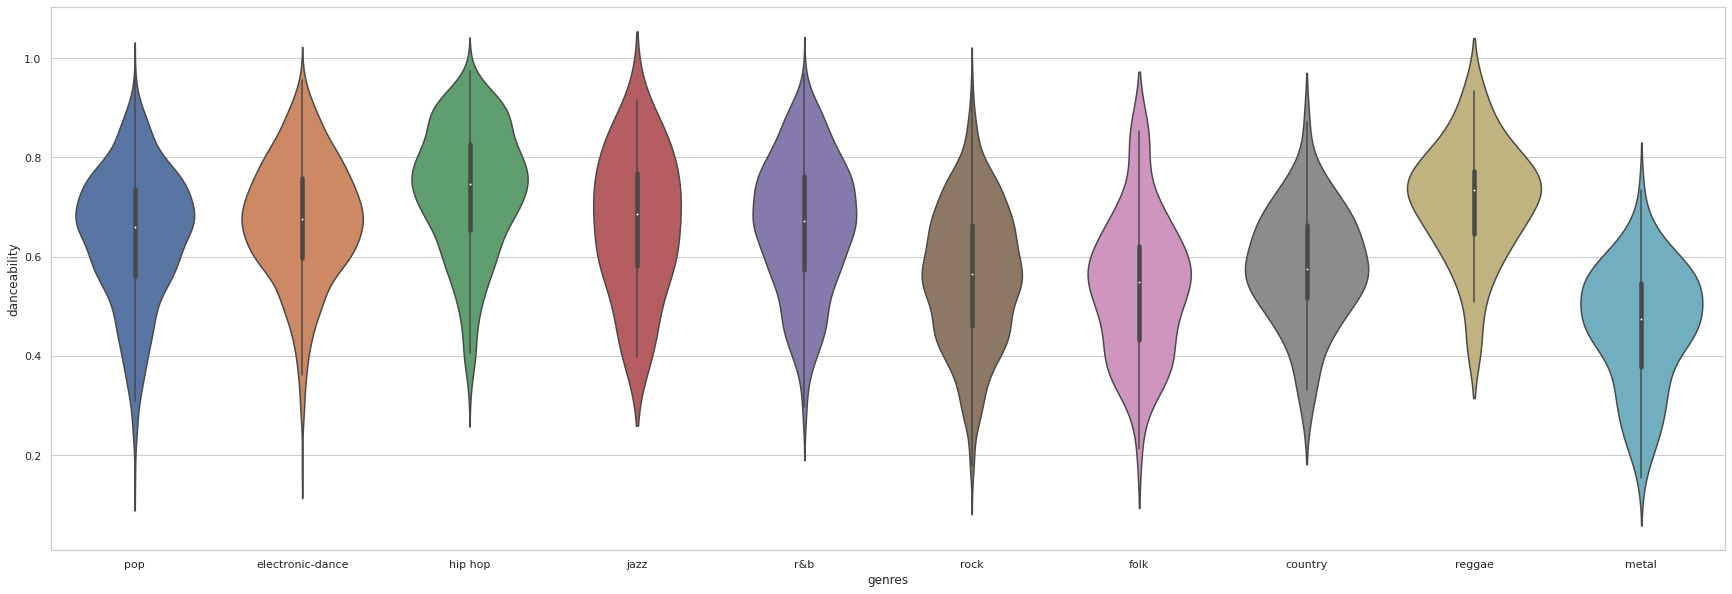

In [22]:
plt.figure(figsize=(30, 10))
sns.violinplot(x="genres", y="danceability", data=df_with_genre)


<AxesSubplot:xlabel='genres', ylabel='loudness'>

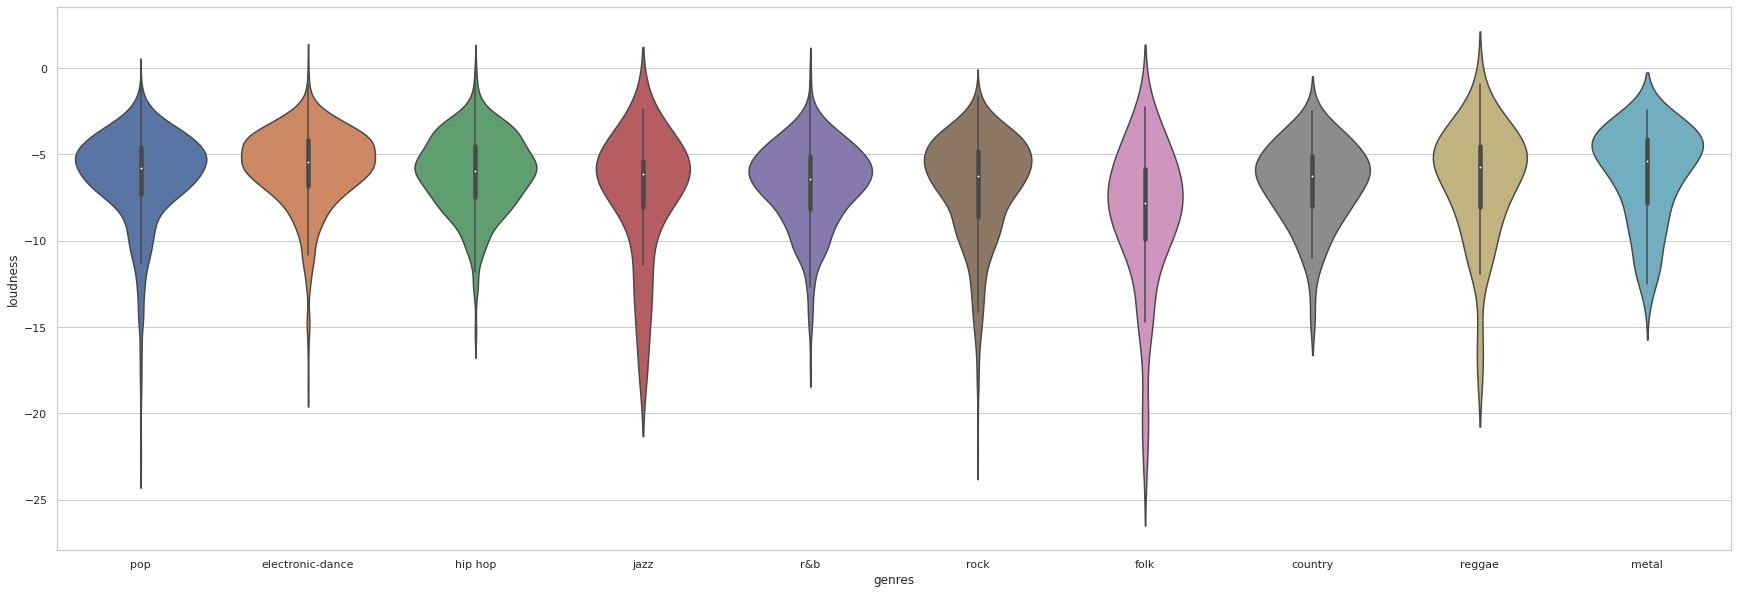

In [23]:
plt.figure(figsize=(30, 10))
sns.violinplot(x="genres", y="loudness", data=df_with_genre)


<AxesSubplot:xlabel='genres', ylabel='energy'>

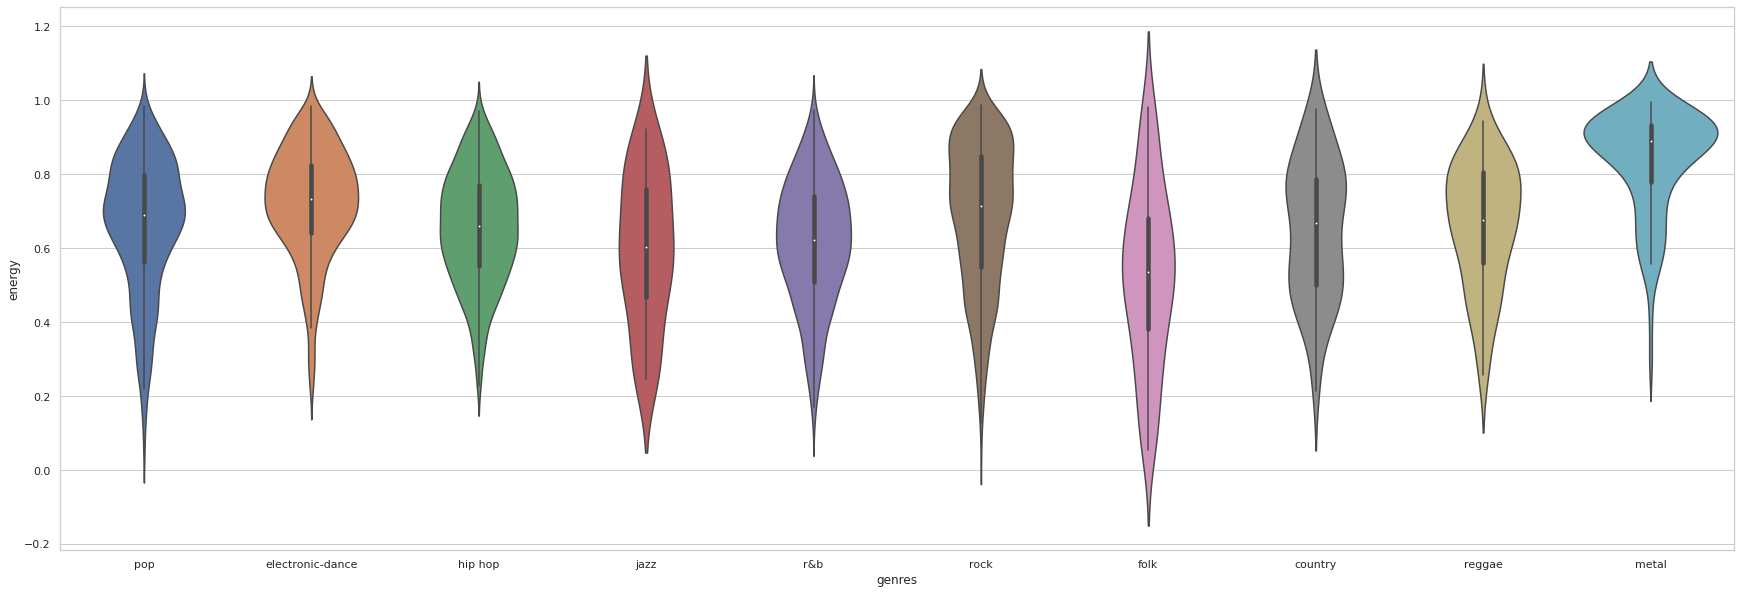

In [24]:
plt.figure(figsize=(30, 10))
sns.violinplot(x="genres", y="energy", data=df_with_genre)


#### Within each genre which mode is more prominent?

In [61]:
genre_mode = df_with_genre.groupby("genres")["mode"].value_counts()
genre_mode = pd.DataFrame(genre_mode).rename(
    columns={'mode': 'count'}).reset_index()
table = pd.pivot_table(genre_mode, values='count', index='mode',
                       columns=['genres'], aggfunc=np.sum)
table = table.astype(int)


def scale(series):
    return series / series.sum()


for col in table.columns:
    table[col] = scale(table[col])
table.head()


genres,country,electronic-dance,folk,hip hop,jazz,metal,pop,r&b,reggae,rock
mode,,,,,,,,,,
major,0.833333,0.492154,0.857143,0.551515,0.588235,0.617647,0.606504,0.576606,0.574468,0.679965
minor,0.166667,0.507846,0.142857,0.448485,0.411765,0.382353,0.393496,0.423394,0.425532,0.320035


<AxesSubplot:xlabel='genres', ylabel='mode'>

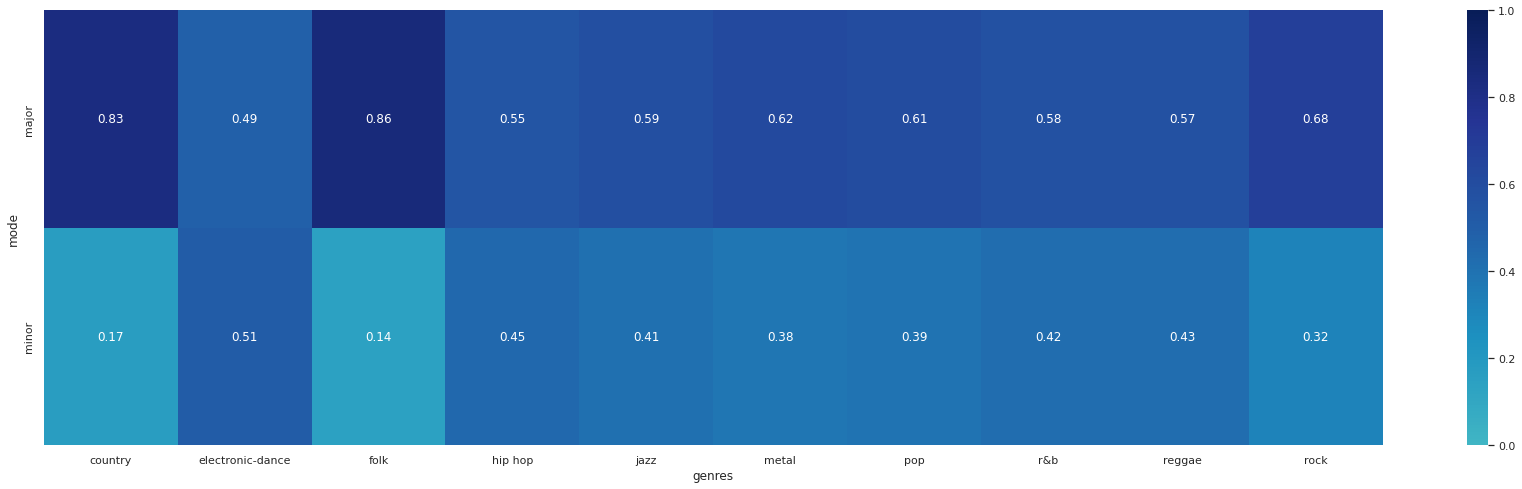

In [64]:
plt.figure(figsize=(30, 8))
# sns.histplot(data=df_with_genre, x="genres", y="mode", cbar=True)
sns.heatmap(table, vmin=0, vmax=1, annot=True, center=0, cmap="YlGnBu")


#### Which combinations of genres appear frequently?

In [43]:
m = ConfusionMatrix(list(df_with_genre["genres"].value_counts().index))
count = df_with_genre["genres"].value_counts()
for genre in count.index:
    m.update_diag(genre, count[genre])

for i, row in df_with_genre.dropna().iterrows():
    if i == 0:
        prev_track = row["track_id"]
        curr_list = [row["genres"]]
        continue
    curr_track = row["track_id"]
    if prev_track != curr_track:
        for pair in findsubsets(curr_list, 2):
            m.increment(pair)
        prev_track = curr_track
        curr_list = [row["genres"]]
    else:
        curr_list.append(row["genres"])
print(m.matrix)
m.normalize()
m.reset_diag()
print(m.matrix)


[[1.230e+03 2.540e+02 1.510e+02 2.960e+02 2.740e+02 4.000e+00 2.500e+01
  1.300e+01 1.400e+01 1.400e+01]
 [2.540e+02 1.128e+03 7.400e+01 9.000e+01 9.200e+01 5.800e+01 2.400e+01
  1.700e+01 1.400e+01 7.000e+00]
 [1.510e+02 7.400e+01 8.250e+02 8.200e+01 1.560e+02 7.000e+00 3.000e+00
  1.000e+00 1.000e+01 6.000e+00]
 [2.960e+02 9.000e+01 8.200e+01 7.010e+02 1.180e+02 1.000e+00 3.000e+00
  6.000e+00 1.200e+01 4.000e+00]
 [2.740e+02 9.200e+01 1.560e+02 1.180e+02 6.070e+02 0.000e+00 8.000e+00
  4.000e+00 6.000e+00 1.600e+01]
 [4.000e+00 5.800e+01 7.000e+00 1.000e+00 0.000e+00 1.020e+02 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [2.500e+01 2.400e+01 3.000e+00 3.000e+00 8.000e+00 0.000e+00 7.000e+01
  7.000e+00 0.000e+00 0.000e+00]
 [1.300e+01 1.700e+01 1.000e+00 6.000e+00 4.000e+00 0.000e+00 7.000e+00
  6.600e+01 0.000e+00 0.000e+00]
 [1.400e+01 1.400e+01 1.000e+01 1.200e+01 6.000e+00 0.000e+00 0.000e+00
  0.000e+00 4.700e+01 1.000e+00]
 [1.400e+01 7.000e+00 6.000e+00 4.000e+00 1.600e+01 0.0

In [45]:
mask = np.zeros_like(m.matrix)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

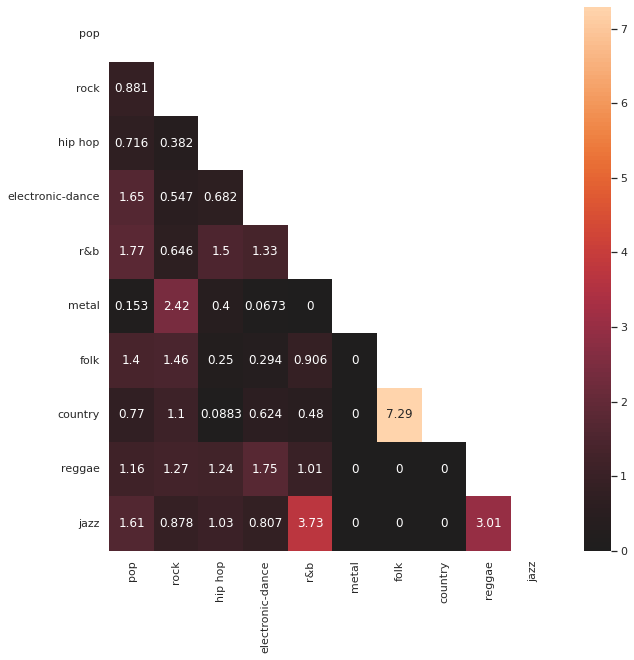

In [47]:
plt.figure(figsize=(10, 10))

sns.heatmap(m.matrix, annot=True, center=0, fmt=".3g", mask=mask,
            xticklabels=m.ele, yticklabels=m.ele)


### Release date analysis
The original data is divided into 7 time periods:
- Before 1980: 225 songs
- 1980s: 177 songs
- 1990s: 222 songs
- 2000s: 521 songs
- From 2010 to 2014: 780 songs
- From 2015 to 2017: 1169 songs
- From 2018 to present: 1366 songs

##### Number of songs released in each 5-year interval

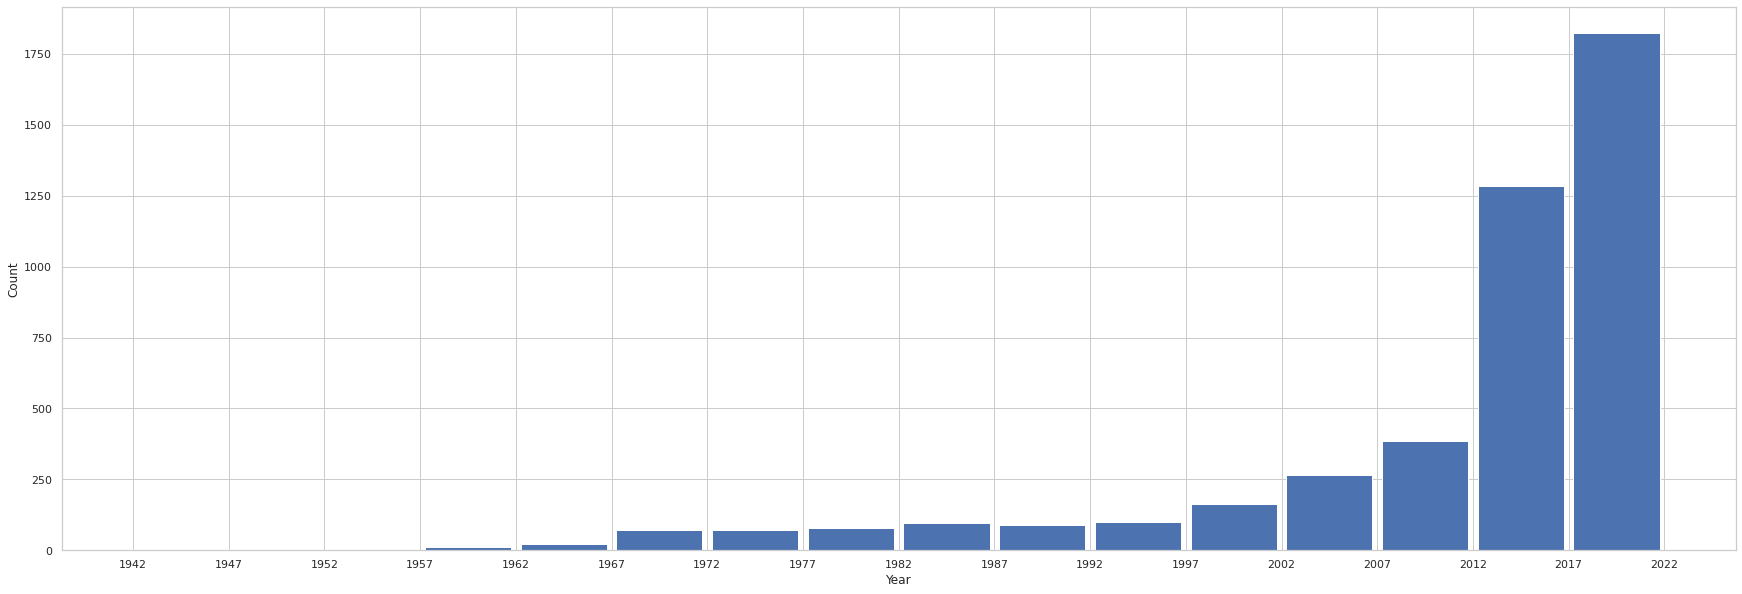

In [ ]:
plt.figure(figsize=(30, 10))
data = df["sp_release_date"]
data = [t.year for t in data]
number = np.arange(min(data), max(data) + 5, 5)
label = map(lambda x: str(x), number)
plt.hist(data, bins=number, rwidth=0.9)
plt.xticks(number, label)
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


#### Average view and playcount by year

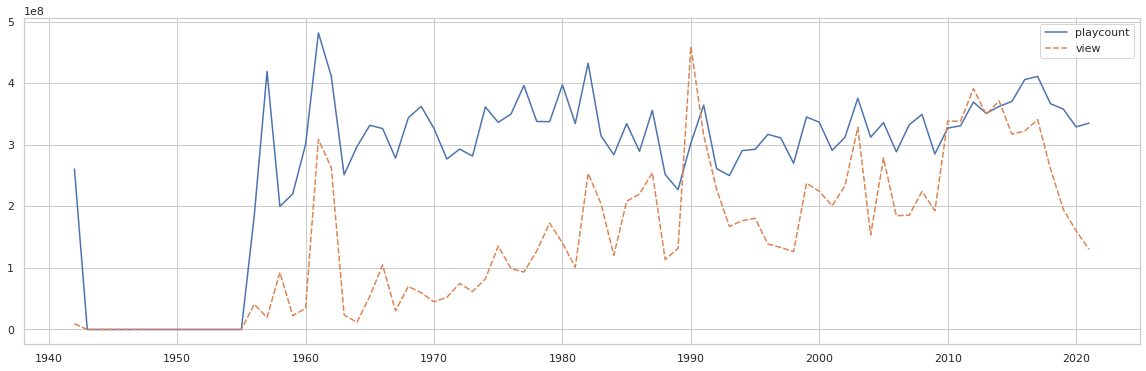

In [71]:
plt.figure(figsize=(20, 6))
plot_popularity_by_year(df)

#### Average view and playcount by time hand-splitted time period

                     playcount          view
year                                        
(-inf, 1980.0]    3.690182e+08  2.289931e+08
(1980.0, 1990.0]  3.627917e+08  2.083622e+08
(1990.0, 2000.0]  3.437863e+08  2.459226e+08
(2000.0, 2010.0]  3.848914e+08  3.341049e+08
(2010.0, 2015.0]  5.308370e+08  5.082553e+08
(2015.0, 2018.0]  4.514605e+08  3.516863e+08
(2018.0, inf]     3.179707e+08  1.900054e+08


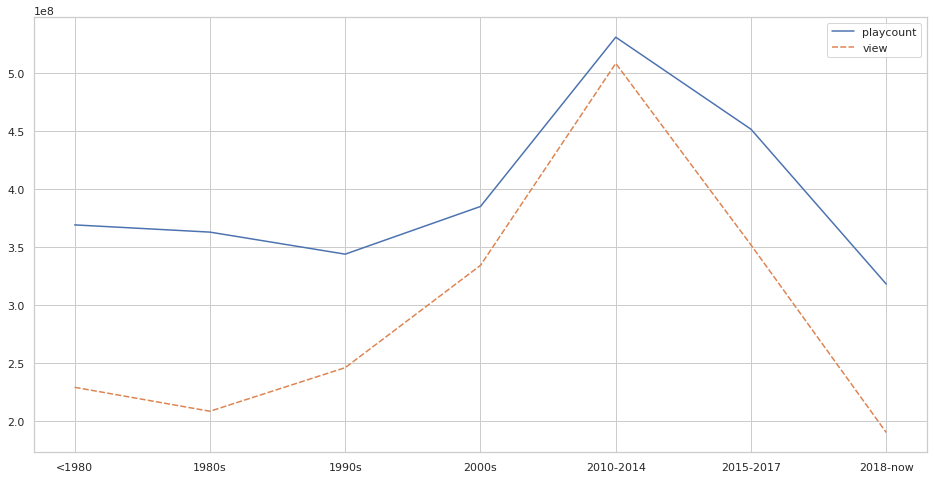

In [41]:
plt.figure(figsize=(16,8))
plot_popularity_by_eras(df_with_genre)

#### Now for each genre

##### By year

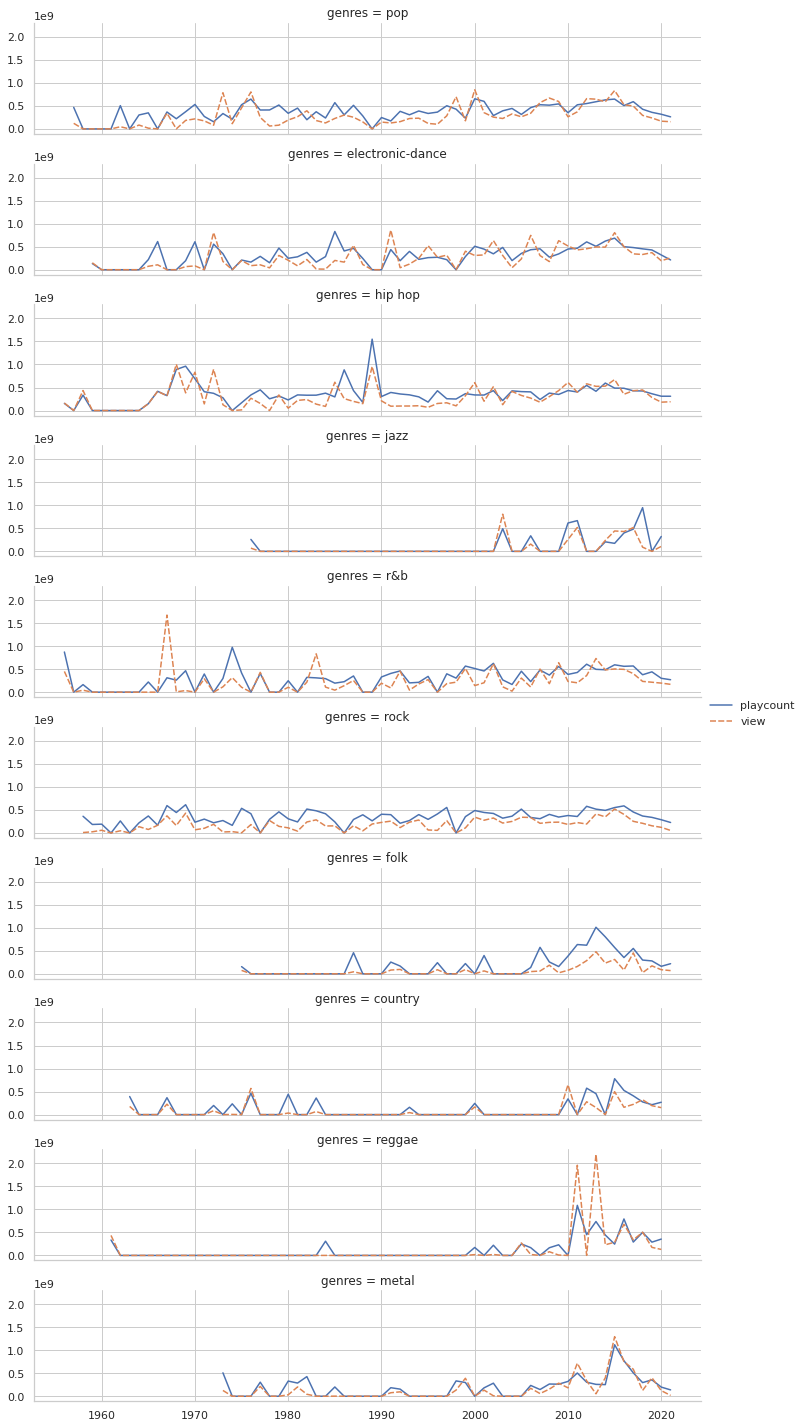

In [42]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
g.map_dataframe(plot_popularity_by_year)
g.add_legend()

##### By time period

                     playcount          view
year                                        
(-inf, 1980.0]    4.127115e+08  2.827387e+08
(1980.0, 1990.0]  3.612203e+08  2.140224e+08
(1990.0, 2000.0]  3.999178e+08  3.446465e+08
(2000.0, 2010.0]  4.422304e+08  3.957235e+08
(2010.0, 2015.0]  6.026394e+08  6.627870e+08
(2015.0, 2018.0]  5.084464e+08  4.337668e+08
(2018.0, inf]     3.366116e+08  2.075245e+08
                     playcount          view
year                                        
(-inf, 1980.0]    3.091081e+08  2.066629e+08
(1980.0, 1990.0]  3.584728e+08  1.669703e+08
(1990.0, 2000.0]  3.097378e+08  3.627335e+08
(2000.0, 2010.0]  3.822428e+08  4.093406e+08
(2010.0, 2015.0]  5.956095e+08  5.692017e+08
(2015.0, 2018.0]  4.752782e+08  3.859713e+08
(2018.0, inf]     3.635729e+08  2.984827e+08
                     playcount          view
year                                        
(-inf, 1980.0]    4.025700e+08  3.602476e+08
(1980.0, 1990.0]  4.380827e+08  2.466512e+08
(1990.0, 2

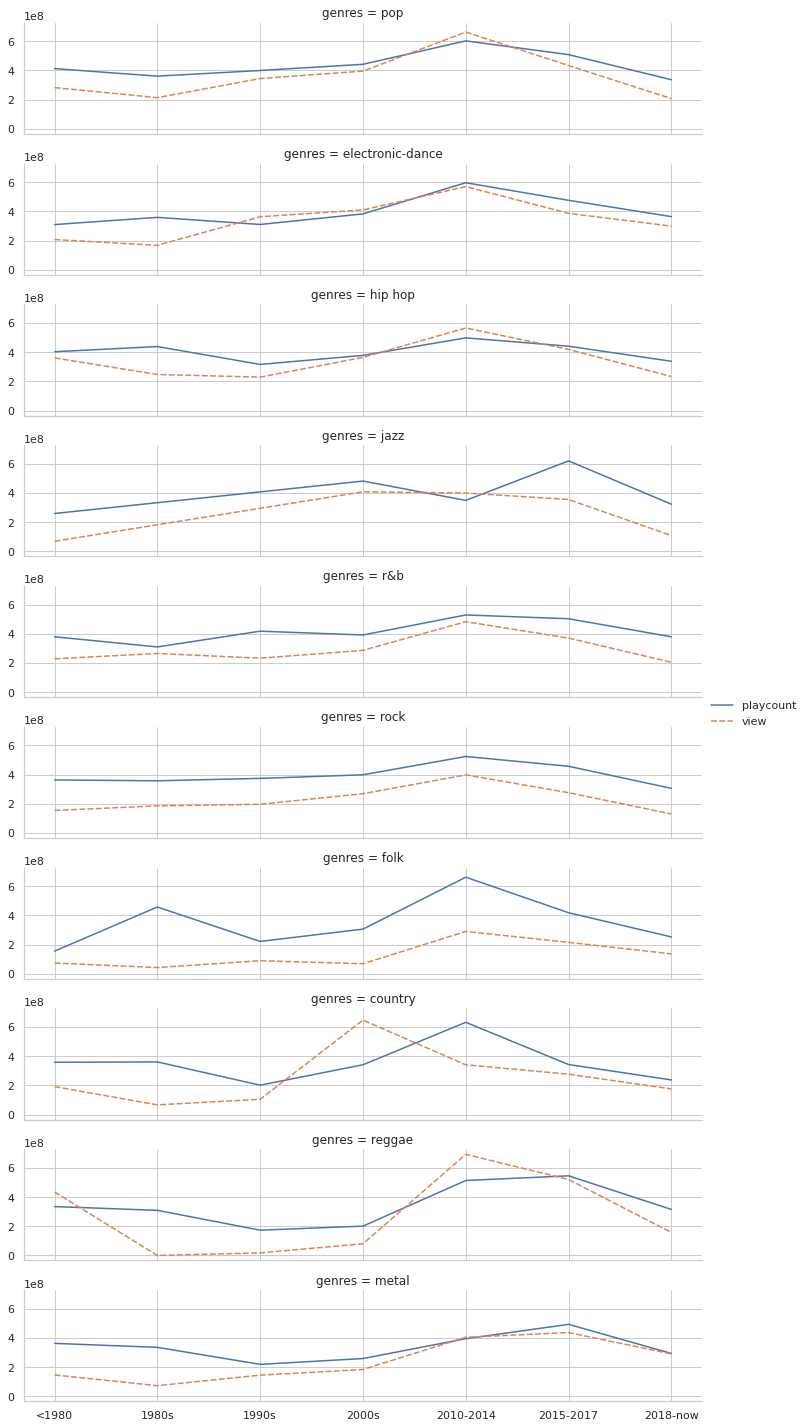

In [43]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
g.map_dataframe(plot_popularity_by_eras)
g.add_legend()

### Parallel plot

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df[''],
                   colorscale = 'Electric',
                   showscale = True)
                #    cmin = -4000,
                #    cmax = -100)
        dimensions = list([
            dict(range = [32000,227900],
               #   constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)

In [40]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(range = [32000,227900],
               #   constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()

In [39]:
fig = px.parallel_coordinates(df[['valence', 'tempo', 'danceability', 'energy']], color='energy')
fig.show()

In [27]:
df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2
                             )
fig.show()

#### Miscellaneous

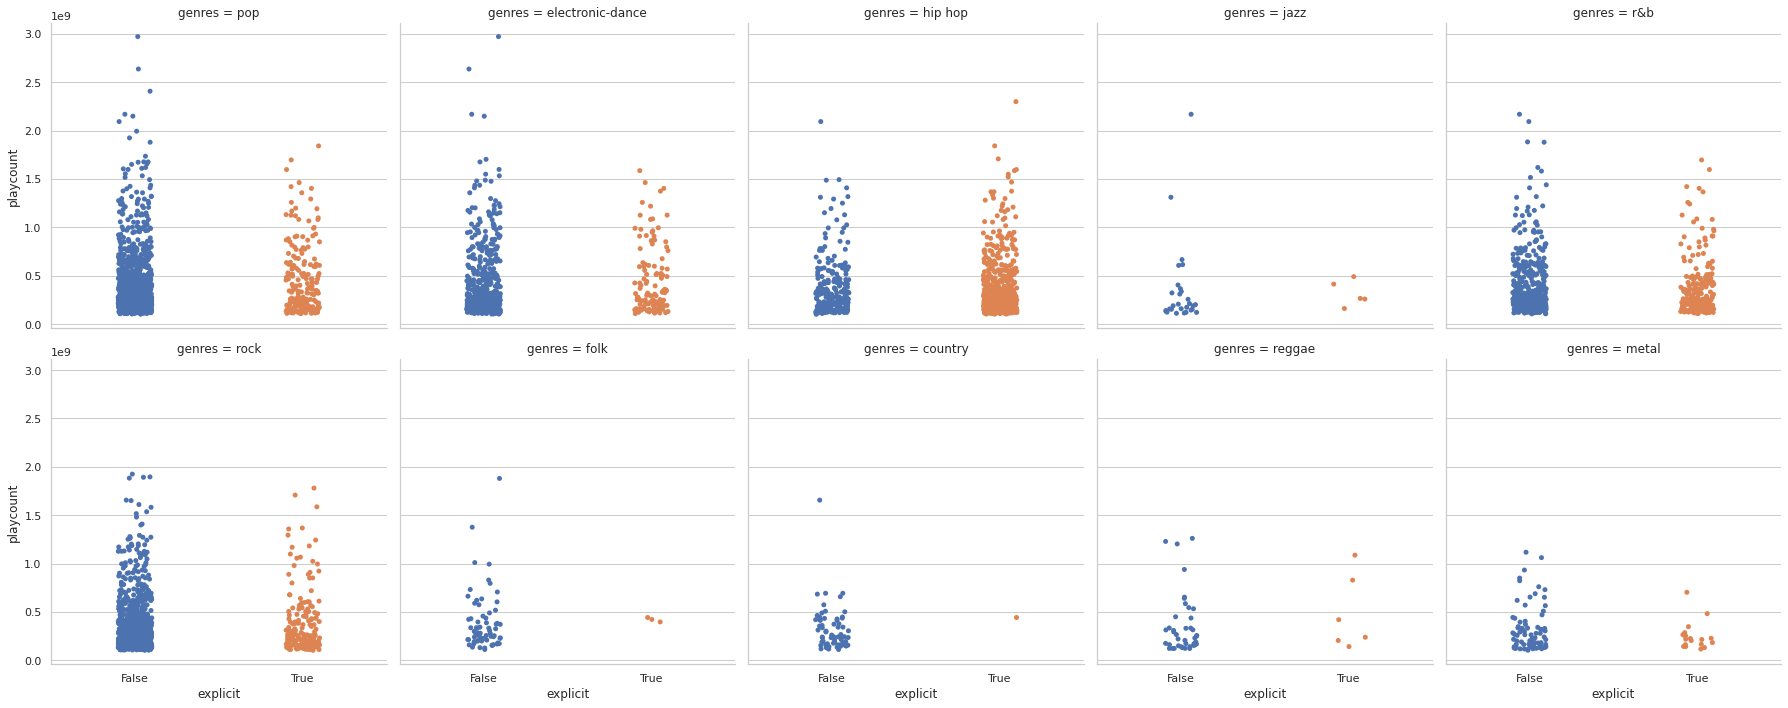

In [ ]:
sns.catplot(x="explicit", y="playcount",
            col="mode", data=df_with_genre, col_wrap=5)